In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pymarket import Market
from pymarket.bids.demand_curves import demand_curve_from_bids, supply_curve_from_bids
from pymarket.plot import plot_demand_curves

# Creates new market

In [2]:
r = np.random.RandomState(1234)
mar = Market()
    
mar.accept_bid(1, 6.7, 0, True, 0)
mar.accept_bid(1, 6.6, 1, True, 0)
mar.accept_bid(1, 6.5, 2, True, 0)
mar.accept_bid(1, 6.4, 3, True, 0)
mar.accept_bid(1, 6.3, 4, True, 0)
mar.accept_bid(1, 6, 5, True, 0)

mar.accept_bid(1, 1, 6, False, 0)
mar.accept_bid(1, 2, 7, False, 0)
mar.accept_bid(2, 3, 8, False, 0)
mar.accept_bid(2, 4, 9, False, 0)
mar.accept_bid(1, 6.1, 10, False, 0)

bids = mar.bm.get_df()
transactions, extras = mar.run('p2p', r=r)
stats = mar.statistics()

In [88]:
bids

,quantity,price,user,buying,time,divisible
0,1,6.7,0,True,0,True
1,1,6.6,1,True,0,True
2,1,6.5,2,True,0,True
3,1,6.4,3,True,0,True
4,1,6.3,4,True,0,True
5,1,6.0,5,True,0,True
6,1,1.0,6,False,0,True
7,1,2.0,7,False,0,True
8,2,3.0,8,False,0,True
9,2,4.0,9,False,0,True


## Orignal supply and demand curves

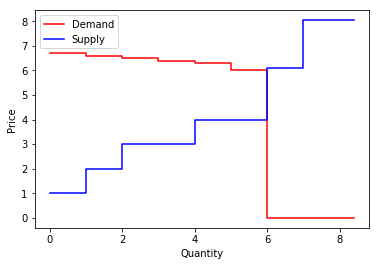

In [3]:
mar.plot()

## Trades among participants

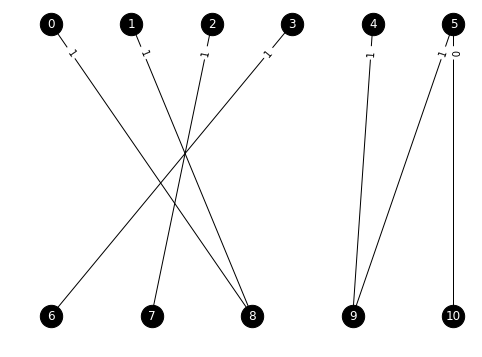

In [82]:
tmp = transactions.get_df()
tmp['user_1'] = tmp.bid.map(bids.user)
tmp['user_2'] = tmp.source.map(bids.user)
tmp['buying'] = tmp.bid.map(bids.buying)
buyers = bids.loc[bids['buying']].index.values

G = nx.from_pandas_edgelist(tmp, 'user_1', 'user_2', ['quantity'])

edge_labels = {}
for (x,y), v in tmp.set_index(['user_1', 'user_2'])['quantity'].to_dict().items():
    if ((x, y) not in edge_labels and (y, x) not in edge_labels):
        edge_labels[(x,y)] = v

fig, ax = plt.subplots(figsize=(8, 6))
pos = nx.bipartite_layout(G, buyers, align='horizontal', scale=3)
_ = nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_color='k', node_size=500)
_ = nx.draw_networkx_labels(G, pos=pos, ax=ax, font_color='w')
_ = nx.draw_networkx_edges(G, pos=pos, label=G, ax=ax)
_ = nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, label_pos=0.9, ax=ax)
_ = ax.axis('off')

In [87]:
extras

{'trading_list': [[(3, 6), (5, 10), (2, 7), (4, 9), (0, 8)], [(5, 9), (1, 8)]]}

## Analysis of the results

### Round 1

* 3 trades with 6, they both trade all their quantity and are not considered for next round
* 5 trades with 10, the asked price by 10 is to high and no trade happens, they continue in next round
* 2 trades with 7, they both trade all their quantity and are not considered for next round
* 4 trades with 9, they trade one unit and 9 goes to next one with one remaining unit
* 0 trades with 8, they trade one unit and 8 goes to next one with one remaining unit
* 1 is not paired with anyone and continues to round 2

### Round 2

* 5 trades with 9, they both trade all their remaining quantity and are not considered for the next round
* 1 trades with 8, they both trade all their remaining quantity and are not considered for the next round
* 10 is not paired and continues to the round 3

### Round 3

* Only 10 remains, so no trade can ocurr, the algorithm ends.

# Statistics

In [83]:
print('Percentage of the maximum possible traded quantity')
stats['percentage_traded']

Percentage of the maximum possible traded quantity


0.9999999999989999

In [84]:
print('Percentage of the maximum possible total welfare')
stats['percentage_welfare']

Percentage of the maximum possible total welfare


1.0

In [85]:
print('Profits per user')
for u in bids.user.unique():
    print(f'User {u:2} obtained a profit of {stats["profits"]["player_bid"][u]:0.2f}')

Profits per user
User  0 obtained a profit of 1.85
User  1 obtained a profit of 1.80
User  2 obtained a profit of 2.25
User  3 obtained a profit of 2.70
User  4 obtained a profit of 1.15
User  5 obtained a profit of 1.00
User  6 obtained a profit of 2.70
User  7 obtained a profit of 2.25
User  8 obtained a profit of 3.65
User  9 obtained a profit of 2.15
User 10 obtained a profit of 0.00


In [86]:
print(f'Profit to Market Maker was {stats["profits"]["market"]:0.2f}')

Profit to Market Maker was 0.00
